## Optimal Control in Practice

Here are some examples to show implementation of optimal control in Julia.

In [1]:
using DifferentialEquations, Plots, NLsolve, LinearAlgebra, ForwardDiff, Optim

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1273


In [2]:
gr(fmt=:png); # setting for easier graph display in jupyter notebooks

### Lifecycle Problem
We can illustrate using the simplest and most canonical intertemporal optimization problems in economics, the lifecycle savings problem. Here, the only choice is whether to consume now or consume later. You get felicity $u(c)$ from consuming $c$ at any time. You like consuming $u^{\prime}(c)>0$ but have declining marginal utility of consumption $u^{\prime\prime}(c)<0$, and are impatient, discounting future consumption at rate $\rho$. You may invest in assets $A$ (think of these as real capital, like seed corn for a farm) which can be used to produce $f(A)$ at any time, supplemented by fixed wage w. Whetever you do not consume is saved, augmenting $A$. You start at $0.0001$ initial wealth and are requird to have assets 0.1 at final time $T$.  
In equations, all of that said you solve

$$\max_{\{c_t\}_{t=0}^T} \int_{0}^{T} e^{-\rho t} u(c) dt $$
$$\text{s.t. } \dot{A} = f(A)+w-c$$
$$A(0)=0.0001, A(T)=0.1$$

The optimality conditions for this are given by Pontryagin's maximum principle. Define the Hamiltonian
$$H(A,c,\lambda,t) = u(c_t) + \lambda_t[f(A_t)+w-c_t]$$
optimality requires
1) Optimization $c=\arg\max_c H$
$$0=\frac{dH}{dc}=u^{\prime}(c)-\lambda$$
2) Costate evolution $\dot{\lambda}=\rho\lambda-\frac{dH}{dA}$
$$\dot{\lambda}=\rho\lambda-\lambda[f^{\prime}(A)]$$
3) Initial condition
$$A(0)=0.0001$$
4) Terminal condition
$$A(T)=0.1$$

Going through some simplifying algebra, this can be rewritten as
$$\dot{c}=\frac{u^{\prime}(c)}{u^{\prime\prime}(c)}(\rho-f^{\prime}(A))$$
$$\dot{A}=f(A)+w-c$$
$$A(0)=0.001, A(T)=0.1$$

We will solve this numerically by shooting. Assume log utility and Cobb Douglass production function $Zk^\alpha$, and some arbitrary other parameters. This turns the equation into
$$\dot{c}=-c\cdot(\rho-\alpha Z(A)^{\alpha-1})$$
$$\dot{A}=ZA^{\alpha}+w-c$$
$$A(0)=A(T)=0$$
Cobb Douglass is great for theory and local approximations but gums up the works for global numerics, because it is undefined for negative capital. This is why we set up the problem so initial and terminal conditions are not 0 but somewhat above it.

In [106]:
Z = 1.0 #Normalization
ρ = 0.03 #Standard
w = 1.0 #Arbitrary
α = 0.33 #Standard

p = (Z, ρ, w, α) #Collect parameters

T = 60.0  #Working years to retirement 
Ts = (0.0,T) #Lifespan
A0 = 0.0001 #Marginal product not defined if initial wealth is 0 
AT = 0.1 #Must be nonzero for same reason

function lifecycle!(du,u,p,t)
    Z, ρ, w, α = p
    du[1] = -u[1]*(ρ-α*Z*(u[2])^(α-1))
    du[2] = Z*(u[2])^(α) + w - u[1]
end

lifecycle! (generic function with 1 method)

In [107]:
#Test it out by solving for arbitrary initial consumption
cguess1 = 0.2
u0=[cguess1 A0]
guessprob = ODEProblem(lifecycle!,u0,Ts,p)
guesspath = solve(guessprob)

retcode: Success
Interpolation: Automatic order switching interpolation
t: 29-element Array{Float64,1}:
  0.0                  
  0.001270176509662767 
  0.0020368010415968436
  0.004103709782392795 
  0.006505592557097246 
  0.010675532136749127 
  0.01657577424422551  
  0.02575729771021299  
  0.03932591553915824  
  0.05978050962502581  
  0.09015300310132653  
  0.1353325927792151   
  0.20210101831331256  
  ⋮                    
  1.4078194781218722   
  2.049068870718492    
  2.9688887219383124   
  4.281349535402958    
  6.1439958146800295   
  8.773934292683423    
 12.471851421864198    
 17.662764458090187    
 24.98841721103463     
 35.54869820580385     
 50.274546686233926    
 60.0                  
u: 29-element Array{Array{Float64,2},1}:
 [0.2 0.0001]                               
 [0.2150516042117147 0.001212937470227458]  
 [0.21926361370919836 0.0019036399353525846]
 [0.22714055013267842 0.0038062251604003144]
 [0.2336009259142304 0.006069805904943001]  
 [0.24

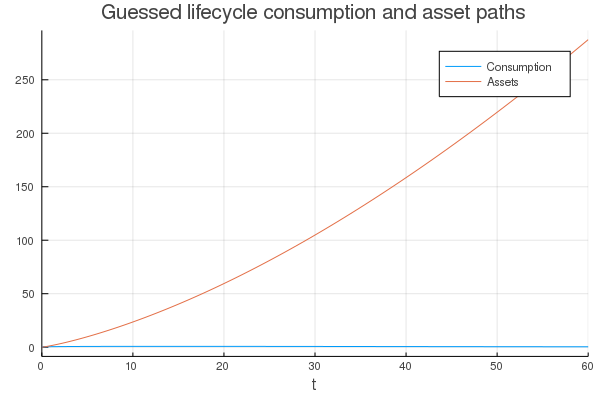

In [108]:
plot(guesspath,vars=(0,1),title="Guessed lifecycle consumption and asset paths",labels="Consumption")
plot!(guesspath,vars=(0,2),labels="Assets")

We see that the above result is not a solution: the agent consumes too little and saves too much, so the terminal condition isn't satisfied.  To code a shooting method, enclose the solver in a function and use a nonlinear equation solver to find the initial condition that gives a solution with the right terminal condition.

In [109]:
guesspath.u[end][2] #Assets at end of life

287.5233720383619

In [110]:
function lifecycleshoot(c0)
    Z = 1.0 #Normalization
    ρ = 0.03 #Standard
    w = 1.0 #Arbitrary
    α = 0.33 #Standard

    p = (Z, ρ, w, α) #Collect parameters

    T = 60.0  #Working years to retirement 
    Ts = (0.0,T) #Lifespan
    A0 = 0.0001 #Marginal product not defined if initial wealth is 0 
    AT = 0.1 #Must be nonzero for same reason
    
    u0=[c0 A0]
    guessprob = ODEProblem(lifecycle!,u0,Ts,p)
    guesspath = solve(guessprob,save_everystep=false,save_start = false) #Only save the terminal condition, which is what we care about
    return guesspath.u[end][2]-AT
end

lifecycleshoot (generic function with 1 method)

In [111]:
#Verify that the function gives the same answer as above
g2 = lifecycleshoot(cguess1) + AT

287.5233720383619

In [122]:
#Find an upper bracket, being aware that negative wealth yields undefined production
gu = lifecycleshoot(0.340199) #It took a lot of testing to find a number that gave negative output but didn't return an error.

-0.0987318110329301

In [17]:
#solve using univariate solver from Roots
using Roots

In [123]:
copt = fzero(lifecycleshoot,0.2,0.340199)

0.3401983558291578

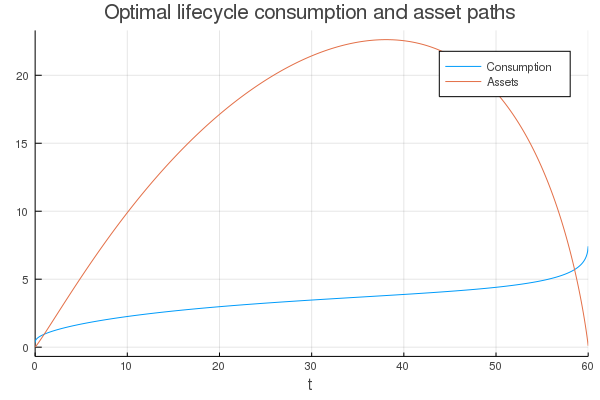

In [125]:
#Now display trajectory
uopt=[copt A0]
optprob = ODEProblem(lifecycle!,uopt,Ts,p)
optpath = solve(optprob)
plot(optpath,vars=(0,1),title="Optimal lifecycle consumption and asset paths",labels="Consumption")
plot!(optpath,vars=(0,2),labels="Assets")

It can help a lot for qualitative intuition to display problems like this in *phase space*, comparing variables to each other instead of over time.

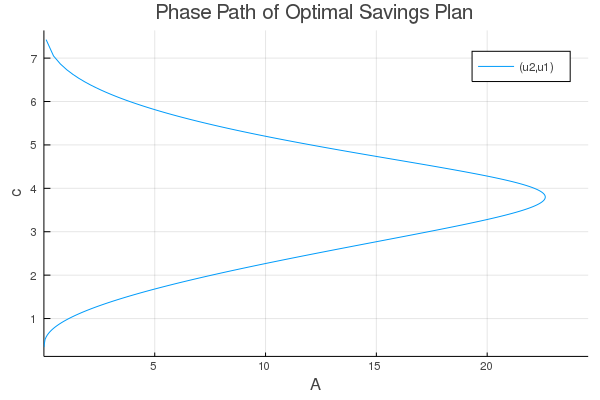

In [127]:
plot(optpath,vars=(2,1),title="Phase Path of Optimal Savings Plan",xlab="A",ylab="c")

In [133]:
#You could solve this in other ways, e.g. by minimizing error
copt2 = optimize(c->(lifecycleshoot(c))^2, 0.2,0.340199)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.200000, 0.340199]
 * Minimizer: 3.401984e-01
 * Minimum: 1.129496e-07
 * Iterations: 28
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 29

In [134]:
copt2.minimizer

0.34019835813268257

In [137]:
#Maybe this would be more robust with complex arithmetic. Let's see if this is true.
lifecycleshoot(0.2+0.0im)

287.63637603635686 + 0.0im

In [138]:
lifecycleshoot(0.35+0.0im) #This should be imaginary

72.36173291722143 + 177.45178035216676im

Trying various methods, this might work in principle, but most nonlinear solvers ayield errors for complex root-finding, so I would have to write my own. That's worthwhile if we are going to try to, for example, fit the parameters of this model, in which case it would need to be solved many times in a loop.

### Infinite Horizon
In the case where the agent is immortal (or equivalently, does not have a known fixed time of death but a random one without fixed bound), you can't simply shoot to the end. One option is to compute a steady state, pretend it is reached in finite but large T, and then forward shoot until you are close. This has the difficulty that the forward system in general optimal control problems is *unstable*, meaning you will get divergence to infinity very quickly for guesses that are above or below the true value. 

In this setting, an alternative bet is *reverse shooting*: start at a steady state, reverse time, and shoot backwards to hit the initial conditions. This has improved stability properties. However, the nontrivial additional issue is that at a steady state, by definition, the time derivative is 0 and so starting at a steady state you stay there. Instead, what you must do is shoot from an initial condition near the steady state, but close enough that the difference is small. In multiple dimensions, you need also to be on the appropriate side of the steady state. A trick here relies on [Stable Manifold Theorem](https://en.wikipedia.org/wiki/Stable_manifold_theorem). Local to the steady state, a stable optimal path is tangent to the direction along which the eigenvalues of the Jacobian of the system have negative real part. Informally, this means that the linearized system provides a good approximation, so you can start at a point on the linearized solution arbitrarily near to the steady state.

For completeness, the revised system is 
1) Optimization $c=\arg\max_c H$
$$0=\frac{dH}{dc}=u^{\prime}(c)-\lambda$$
2) Costate evolution $\dot{\lambda}=\rho\lambda-\frac{dH}{dA}$
$$\dot{\lambda}=\rho\lambda-\lambda[f^{\prime}(A)]$$
3) Initial condition
$$A(0)=0.0001$$
4) Transversality condition
$$\underset{t\to\infty}{\lim}e^{-\rho t}|\lambda(t)A(t)|=0$$

Going through some simplifying algebra, this can be rewritten as
$$\dot{c}=\frac{u^{\prime}(c)}{u^{\prime\prime}(c)}(\rho-f^{\prime}(A))$$
$$\dot{A}=f(A)+w-c$$
$$A(0)=0.0001$$
$$\underset{t\to\infty}{\lim}e^{-\rho t}|u^{\prime}(c(t))A(t)|=0$$

Specializing this to the Cobb Douglass log utility case, have
$$\dot{c}=-c\cdot(\rho-\alpha Z(A)^{\alpha-1})$$
$$\dot{A}=ZA^{\alpha}+w-c$$
$$A(0)=0.0001$$
$$\underset{t\to\infty}{\lim}e^{-\rho t}|u^{\prime}(c(t))A(t)|=0$$

To find the steady state, solve for $\dot{c}=\dot{A}=0$.

In [158]:
function growthout!(z,u)
    Z = 1.0 #Normalization
    ρ = 0.03 #Standard
    w = 1.0 #Arbitrary
    α = 0.33 #Standard
    z[1] = -u[1]*(ρ-α*Z*(u[2])^(α-1))
    z[2] = Z*(u[2])^(α) + w - u[1]
    #z[1] = -u[1]*(0.03-0.33*1.0*(u[2])^(0.33-1))
    #z[2] = 1.0*(u[2])^(0.33) + 1.0 - u[1]
end

uinit = [0.3+0.0im; 1.0+0.0im]

steady = nlsolve(growthout!,uinit)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: Complex{Float64}[0.3 + 0.0im, 1.0 + 0.0im]
 * Zero: Complex{Float64}[4.257802523548471 - 2.872916144101495e-12im, 35.83582775921023 - 1.830281426092907e-10im]
 * Inf-norm of residuals: 0.000000
 * Iterations: 20
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 21
 * Jacobian Calls (df/dx): 16

In [164]:
steadystate=real(steady.zero)

2-element Array{Float64,1}:
  4.257802523548471
 35.83582775921023 

In [166]:
#Linearize around the steady state by calculating Jacobian
y=similar(steadystate) #A place to store in place result
steadyjac = ForwardDiff.jacobian(growthout!,y,steadystate)

2×2 Array{Float64,2}:
 -1.20043e-13  -0.00238816
 -1.0           0.03      

In [170]:
(vals,vecs) = eigen(steadyjac)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
eigenvalues:
2-element Array{Float64,1}:
 -0.03611911496819682
  0.06611911496795674
eigenvectors:
2×2 Array{Float64,2}:
 -0.0659751   0.0360956
 -0.997821   -0.999348 

If we push the system along the first eigenvector, corresponding to negative eigenvalue, locally, the system remains close to the true optimal policy.  In other words, for small $h$, $(c^*,k^*)+h\cdot v^1$ is approximately a solution to the system, or $c(k)\approx c^* + \frac{v_1^1}{v_2^1}(k-k^*)$ near steady state.

In [186]:
clin(k) = steadystate[1]+(vecs[1,1]/vecs[2,1])*(k-steadystate[2])

clin (generic function with 1 method)

In [255]:
cpt = 1.2:0.4:5.0
kpt = 0.01:2.0:50

x = repeat(kpt,inner=length(cpt))
y = repeat(cpt,outer=length(kpt))

# Time derivatives at each point
u = -y.*(ρ .- α*Z*(x).^(α-1))
v = Z*(x).^(α) .+ w .- y

250-element Array{Float64,1}:
  0.018776162394955387
 -0.38122383760504475 
 -0.7812238376050447  
 -1.1812238376050446  
 -1.5812238376050445  
 -1.9812238376050448  
 -2.3812238376050447  
 -2.7812238376050447  
 -3.181223837605045   
 -3.5812238376050445  
  1.0590839821564184  
  0.6590839821564183  
  0.25908398215641837 
  ⋮                   
  0.13786483837821706 
 -0.2621351616217824  
  3.387892836086796   
  2.9878928360867962  
  2.5878928360867963  
  2.1878928360867964  
  1.7878928360867965  
  1.3878928360867961  
  0.9878928360867962  
  0.5878928360867963  
  0.18789283608679597 
 -0.2121071639132035  

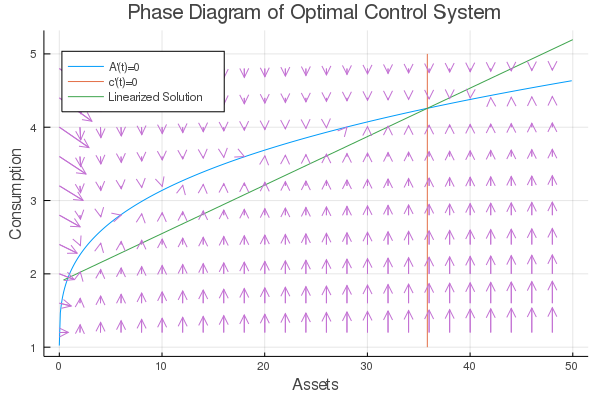

In [317]:
#Plot phase diagram with nullclines and approximate stable manifold
kgrid = 0.00001:0.1:50
kresgrid = 0.4:0.1:50
cgrid = 1.0:0.01:5.0
cbar = steadystate[2]*ones(length(cgrid))




plot(kgrid,Z*(kgrid).^(α) .+ w,title="Phase Diagram of Optimal Control System",label="A'(t)=0",legend=:topleft)
plot!(cbar,cgrid,label="c'(t)=0")
plot!(kresgrid,clin.(kresgrid),label="Linearized Solution")
quiver!(x,y,quiver=(0.1*u,0.1*v))
xlabel!("Assets")
ylabel!("Consumption")

In [318]:
#Reverse Shooting

h = 0.0001 #distance from steady state capital
kend = steadystate[2]-h 
cnearsteady = clin(kend) #Linearized model's guess of consumption at end

ktarget = 2.0 #Starting capital

function reversepath!(du,u,p,t) #time reversed conditions
    Z, ρ, w, α = p
    du[1] = u[1]*(ρ-α*Z*(u[2])^(α-1))
    du[2] = -Z*(u[2])^(α) - w + u[1]
end

T = 355.68  #Fairly long term: increase if error high 
Tlong = (0.0,T) #truncated interval

rprob1=ODEProblem(reversepath!,[cnearsteady,kend],Tlong,p)
rprobsol = solve(rprob1)

retcode: Success
Interpolation: Automatic order switching interpolation
t: 10-element Array{Float64,1}:
   0.0               
   2.6164287648919315
  28.780716413811245 
 113.38332126506917  
 229.14865429786897  
 304.3203554877391   
 314.7354910921082   
 338.8518405782604   
 351.21895743451734  
 355.68              
u: 10-element Array{Array{Float64,1},1}:
 [4.257795911636974, 35.83572775921023]  
 [4.257795256314298, 35.83571784795527]  
 [4.257783826606497, 35.835544982739194] 
 [4.257419230932751, 35.83003094635644]  
 [4.23586697436839, 35.504758179641435]  
 [3.9260404428100233, 30.97165571490782] 
 [3.7711200486127336, 28.72708300588567] 
 [3.0346781859295633, 18.940705995428356]
 [2.204148223272928, 9.680448119679495]  
 [1.713283480409067, 5.352607078649966]  

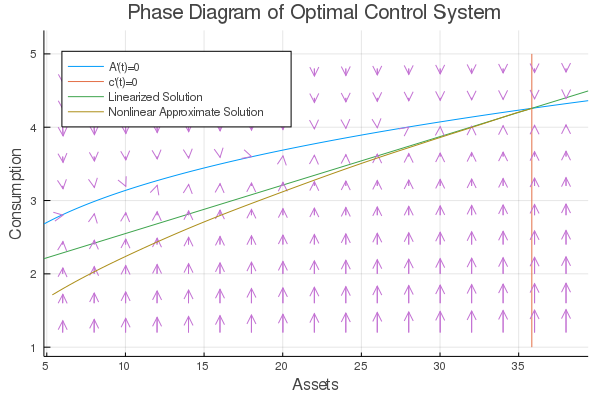

In [319]:
plot!(rprobsol,vars=(2,1),label="Nonlinear Approximate Solution")

This could be fine tuned further by moving closer to steady state, or putting inside a reverse shooting loop to tune the c near the steady state. Doing so would require taking a stand on hitting a particular $k_0$ at a particular maximum time $T$. This is a reasonable thing to do if linearization is a challenge and so the guess of $c$ near the steady state is not based on principle.

### Stochastic Problem
In many situations, it makes more sense to work with a model with a random component. This may be because risk is an economically important feature affecting decisions, or can be used to match heterogeneity and deviations from the model as seen in the data. To the above (infinite horizon) problem, consider a situation where assets are risky, which we will model by stochastic depreciation: the asset stock rises or falls in any period according to a square root volatility process. In diffusion notation, the law of motion for assets becomes
$$dA_t=(f(A_t)+w-c_t)dt + \sigma \sqrt{A_t}dW_t$$
equivalently, in stochastic integral notation
$$A(t) = \int_{0}^{t}(f(A(s))+w-c(s))ds + \int_{0}^{t}\sigma \sqrt{A(s)}dW_s$$ 
where the integral is taken in the Ito sense and $W(t)$ is a standard Brownian motion, $W(0)=0$, $W(t+s)-W(t)\sim N(0,s)$ for any $t,s>0$

The optimization problem becomes
$$\max_{\{c_t\}_{t=0}^T} E_0\int_{0}^{\infty} e^{-\rho t} u(c) dt $$
$$\text{s.t. } dA_t=(f(A_t)+w-c_t)dt + \sigma \sqrt{A_t}dW_t$$
$$A(0)=A_0$$

For the stochastic problem, it will be much easier to use a recursive representation. Standard derivations show that the agent's HJB equation takes the form
$$\rho V(A) = \underset{c}{\max}\{u(c)+V^\prime(A)(f(A)+w-c)+\frac{\sigma^2}{2} AV^{\prime\prime}(A)\}$$

Assume again log utility and Cobb-Douglas production. Then the HJB equation can be written as 
$$\rho V(A) = \underset{c}{\max}\{\log(c)+V^\prime(A)(ZA^{\alpha}+w-c)+\frac{\sigma^2}{2} AV^{\prime\prime}(A)\}$$
Taking first order conditions, obtain $\frac{1}{c}=V^\prime(A)$ so $c=(V^\prime(A))^{-1}$. Substituting in, obtain
$$\rho V(A) = -\log(V^\prime(A))+V^\prime(A)(ZA^{\alpha}+w-(V^\prime(A))^{-1})+\frac{\sigma^2}{2} AV^{\prime\prime}(A)\}$$
Our goal will be to numerically solve this Bellman equation to find the value function $V(A)$, which will then imply a policy function through the optimization rule.

### Methods
The approach will be to follow the finite difference based approach outlined in Ben Moll's notes: see [the technical appendix for the paper](https://benjaminmoll.com/wp-content/uploads/2020/02/HACT_Numerical_Appendix.pdf) and slides on [nonstochastic](https://benjaminmoll.com/wp-content/uploads/2019/07/Lecture3_2149.pdf) and [stochastic](https://benjaminmoll.com/wp-content/uploads/2019/07/Lecture4_2149.pdf) HJB equations. The upshot is that $V(A)$ can be represented on a grid by a vector $\mathbf{v}$, and derivatives by the first and second finite differences. Utility can also be represented on this grid, replacing the derivatives in the optimizer by the corresponding finite difference at the grid point. The discretized HJB equation takes form
$$\rho\mathbf{v} = \mathbf{u}(\mathbf{v}) +M\mathbf{v}$$
where $M$ is a matrix representing the differential operator $(ZA^{\alpha}+w-c)\frac{d}{dA}+\frac{\sigma^2}{2} A\frac{d^2}{dA^2}$ applied to $V(A)$ and $\mathbf{u}(\mathbf{v})$ represents utility, with consumption solved out.

Solutions can be found by a continuous analogue of value function iteration. Consider an $n\in[0,\infty]$ representing progress, so $V(A,n)$ is a flow starting at an arbitrary initial guess $V(A,0)$ which converges towards a solution to the HJB equation as $n\to\infty$ according to equation

$$\frac{d}{dn}V(A,n)+\rho V(A,n) = \underset{c}{\max}\{\log(c)+V^\prime(A,n)(ZA^{\alpha}+w-c)+\frac{\sigma^2}{2} AV^{\prime\prime}(A,n)\}$$

Clearly, any solution to the above equation such that $\frac{d}{dN}V(A,n)=0$ solves the original HJB equation. Numerically, we can find this by applying an Euler method to the initial value problem, discretizing in time and space. If the time step is $\Delta$, the explicit Euler equation is

$$\frac{\mathbf{v}^{n+1}-\mathbf{v}^n}{\Delta}+\rho\mathbf{v}^{n} = \mathbf{u}(\mathbf{v}^{n}) +M\mathbf{v}^{n}$$

The implicit Euler update instead takes the form 
$$\frac{\mathbf{v}^{n+1}-\mathbf{v}^n}{\Delta}+\rho\mathbf{v}^{n+1} = \mathbf{u}(\mathbf{v}^{n}) +M\mathbf{v}^{n+1}$$
Rearranging, obtain
$$((\rho+\frac{1}{\Delta})I-M)\mathbf{v}^{n+1}=\mathbf{u}(\mathbf{v}^{n})+\frac{1}{\Delta}\mathbf{v}^n$$
which can be found with a (sparse) linear system solve. The advantage of the implicit method is time steps can be arbitrarily large and still stable, so many fewer updates are needed.

The main thing that makes this approach tricky is that not every discretization scheme has good properties, in terms of guarantees for approximating an optimal solution. Barles and Souganidis laid out a set of sufficient conditions, reviewed in [Moll](https://benjaminmoll.com/wp-content/uploads/2019/07/Lecture3_2149.pdf), the most important of which is for the approximation to be monotone. 

This can be achieved by using a forward difference $v^{\prime}_{i,F}=\frac{v_{i+1}-v_{i}}{\Delta_A}$ when drift of $A$ is positive, and a backward difference $v^{\prime}_{i,B}=\frac{v_{i}-v_{i-1}}{\Delta_A}$ when the drift is negative. Over intervals where drift passes through 0, a central difference $\bar{v}^{\prime}_{i}=\frac{v_{i+1}-v_{i-1}}{2\Delta_A}$ can be used.  Because drift at a grid point itself depends on the derivative, through the FOC, it also may rely on whether forward or backward difference is used.

Here, drift is $s_{i,F}=(A_i^{\alpha}+w-(v^{\prime}_{i,F})^{-1})$ or $s_{i,B}=(A_i^{\alpha}+w-(v^{\prime}_{i,B})^{-1})$. At steady state, drift can be set to 0.

We can then set the derivative at the $i^{th}$ grid point is given by
$$v^{\prime}_i = v^{\prime}_{i,B}1\{s_{i,F}>0\}+v^{\prime}_{i,F}1\{s_{i,B}<0\}+\bar{v}^{\prime}_{i}1\{s_{i,F}<0<s_{i,B}\}$$
(We can ignore other cases due to concavity which gives a monotone drift function, though see Moll for the non-concave case when FOC do not suffice.)

The second derivative is a little easier, since it is always symmetric: we can use the centered second difference approximation
$$v^{\prime\prime}_i = \frac{v_{i+1}-2v_{i} +v_{i-1}}{\Delta_A^2}$$

Finally, at the boundaries, some restrictions must be imposed, corresponding to the end-point conditions for the spline representation. These should be chosen based on the problem; for example, with borrowing constraints, one may impose a hard boundary of assets at 0, at which derivative may be discontinuous. Alternately, some stochastic processes have reflecting boundaries, where the first derivative is set to 0 at the end points. For representations on a bounded grid of an unbounded process, end point conditions should be such that extrapolation preserves the properties of the value function. In my experience, boundaries which ensure that the second derivative is constant at interior boundaries are useful, as they ensure that concavity is preserved. These all get imposed numerically by adjusting the end conditions of the matrix representing the differential operator, choosing transformations consistent with "ghost nodes" $v_{-1}$, $v_{M+1}$, and so on beyond the grid satisfying the required condition. 

In [326]:
import Pkg; Pkg.add("BandedMatrices") #Install this if not installed
using BandedMatrices #Matrix type which only stores elements on subset of diagonal and offdiagonal elements: speeds up multiply, invert, etc

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %13.3 %>                             ]  26.7 %.2 %>                       ]  40.6 % [======================>                  ]  53.9 %              ]  64.7 % [================================>        ]  78.1 %]  91.3 % Resolving package versions...
 Installed DataAPI ─────────── v1.2.0
 Installed URIParser ───────── v0.4.1
 Installed LearnBase ───────── v0.4.0
 Installed AxisArrays ──────── v0.4.3
 Installed DiffEqJump ──────── v6.6.1
 Installed DiffEqSensitivity ─ v6.13.0
 Installed DSP ─────────────── v0.6.5
 Installed DataStructures ──── v0.17.13
 Installed IRTools ─────────── v0.3.2
 Installed QuasiMonteCarlo ─── v0.2.0
 Installed Cassette ────────── v0.3.3
  Updating `~/.julia/environments/v1.3/Project.toml`
  [aae01518] + BandedMatrices v0.14.3
  Updating `~/.julia/environments/v1.3/Manifest.tom

In [388]:
# Parameters: shared ones same as above
ρ = 0.03
α = 0.33
Z = 1.0
w = 1.0
σ2 = 0.05
# Grids
Amin = 0.5 #Below steady state
Amax = 65  #Above steady state
ng = 200 #Make this small when testing for speed, large for final run for accuracy
ΔA = (Amax-Amin)/ng
A = LinRange(Amin,Amax,ng)
#Initial Guess
v0 = log.(Z*A.^α .+ w)/ρ #Utility of eating current income forever
v = v0
vF = similar(v)
vB = similar(v)
cons = similar(v)
#Algorithm tolerances
maxit = 30
crit = 10^(-6)
ΔN = 100 #time step size
dist = 1000
j = 0; 

In [389]:
while j<maxit && dist>crit
    vdiff = (v[2:ng] .- v[1:(ng-1)])./ΔA
    vdmax = (Z*A[ng]^α + w)^(-1)
    vdmin = (Z*A[1]^α + w)^(-1)
    #Forward finite difference: each element uses difference with one in front of it
    vF[1:(ng-1)] = vdiff
    vF[ng] = vdmax 
    #Backward finite difference: each element uses difference with one in behind it
    vB[2:ng] = vdiff
    vB[1] = vdmin
    #Pad with vdmax and vdmin with understanding that it doesn't get used: just
    #good to have non-0 entry so that everything stays well-defined when inverting

    #Calculate decision and drift using both types of difference
    cF = 1 ./ vF
    cB = 1 ./ vB
    driftF = Z*A.^α .+ w .- cF
    driftB = Z*A.^α .+ w .- cB
    #Calculate consumption when forward drift is not positive and backward drift is not negative 
    #In this case, will use a central difference, and assign as choice the consumption that makes drift 0
    cC = Z*A.^α .+ w
    vC = 1 ./ cC #ensures c(A)=1/V'(A) holds in this case also
    
    #Choose which difference is used so forward is used if drift positive, backward if negative
    GoF = driftF .> 0
    GoB = driftB .< 0
    GoC = (1 .- GoF .- GoB) #Stay in place if neither going forward or backwards
    
    #Combine together to get upwind approximation of V'(k) used for consumption
    vpupwind = vF.*GoF .+ vB.*GoB .+ vC.*GoC
    
    cons = 1 ./ vpupwind #Consumption used for utility function
    util = log.(cons) #Flow utility of consumption
    
    #Now compute V'(A)*drift using Tridiagonal type, which allows fast operations
    #Code uses forward difference if drift positive, backward if negative, central if drift 0
    dfB = -min.(driftB,0.0) ./ ΔA
    difB = dfB[2:ng]
    dfF = max.(driftF,0.0) ./ ΔA
    difF = dfF[1:(ng-1)]
    difC = -max.(driftF,0.0) ./ ΔA .+ min.(driftB,0.0) ./ ΔA
    #Amat*v gives the upwind finite difference approximation of the V'(A)*drift
    Amat = Tridiagonal(difB,difC,difF)
    
    #Add second derivative term by second order differences
    #Terms used in numerical representation of second derivative operator
    el = (σ2/(2*ΔA^2))*ones(ng-1) 
    ecent = -2*(σ2/(2*ΔA^2))*ones(ng)
    er = (σ2/(2*ΔA^2))*ones(ng-1) 
    #Auxiliary terms used in boundary condition computations
    er2 = zeros(ng-2)
    el2 = zeros(ng-2)
    er3 = zeros(ng-3)
    el3 = zeros(ng-3)
    
    #Set second derivatives at boundary to be equal to linear extrapolation of second derivative one
    # and two grid points up: this ensures continuity of second derivatives
    #Following pattern takes coefficients proportional to [2 -5 4 -1]= 2*[1 -2 1 0]-1*[0 1 -2 1]
    # Times the grid points v_1, v_2, v_3, v_4 or v_m, v_m-1, v_m-2, v_m-3, respectively
    
    #Lower boundary
    er3[1]=-1*σ2/(2*ΔA^2)
    er2[1]=4*σ2/(2*ΔA^2)
    er[1]= -5*(σ2/(2*ΔA^2))
    ecent[1]=2*σ2/(2*ΔA^2)
    #Upper boundary
    el3[ng-3]=-1*σ2/(2*ΔA^2)
    el2[ng-2]=4*σ2/(2*ΔA^2)
    el[ng-1]= -5*(σ2/(2*ΔA^2))
    ecent[ng]=2*σ2/(2*ΔA^2)
    #Compute second differences
    diffusemat = BandedMatrix(-3 => el3, -2 => el2, -1 => el, 0 => ecent, 1 => er, 2 => er2, 3 => er3)
    
    #Construct implicit update v_next=v_now+step*HJB(v_next) 
    #where HJB(v) = log(c(A))+v'(A)*drift+diffusion(A)*v''(A)-rho*v(A) 
    Bmat = (ρ+1/ΔN)*I-Amat-Diagonal(A)*diffusemat
    bv = util .+ v/ΔN
    
    #Solve linear system for implicit update.
    vout=Bmat\bv  
    #Since banded matrices used, implicit update nearly as fast as explicit update:
    # implicit method much less sensitive to parameters like step size
    
    dist = maximum(abs.(vout .- v)) #Calculate size of update
    
    v = copy(vout) #Update new guess for next period

    j+=1
end

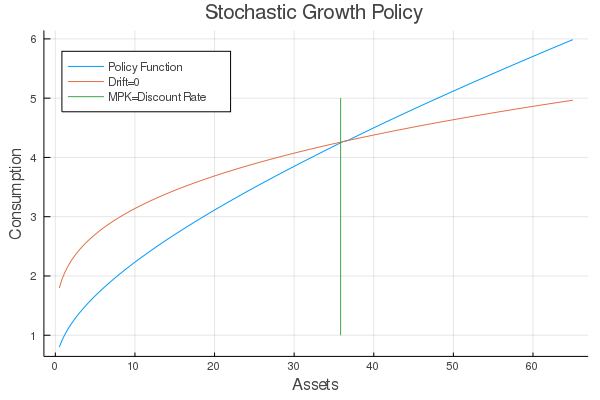

In [390]:
plot(A,cons,label="Policy Function",title="Stochastic Growth Policy",legend=:topleft)
plot!(A,Z*(A).^(α) .+ w,label="Drift=0")
plot!(cbar,cgrid,label="MPK=Discount Rate")
xlabel!("Assets")
ylabel!("Consumption")

In [391]:
# Properties of results
print("Stopped in ",j," iterations, with error ", dist)

Stopped in 8 iterations, with error 8.293034881035055e-7

Although it may be hard to see in the plot above, the policy does not intersect the isoclines of the nonstochastic system. Instead, the point at which consumption is set so that the drift in assets equals 0 is at a slightly higher asst level than the level at which the return on assets equals the discount rate, where it was in the nonstochastic setting. With no risk, when the return is equal to the discount rate, consumption stays constant. With risk (and log utility) the saving rate is higher at any given return on capital: this phenomenon is known as "precautionary savings" and is related to but not quite the same as risk aversion.

#### Simulation

We can generate simulations of implied stochastic growth dynamics using a first order explicit Euler-Maruyama scheme, which is equivalent to adding normal shocks at each iteration of a standard Euler scheme. In equations, if we have a diffusion process
$$dx = \mu(x)dt + \sigma(x)dW$$
$$x(0)=x_0$$
the Euler Maruyama scheme with timestep $\Delta t$ starts at $x^0 = x_0$ and then iterates $T/\Delta t$ times
$$x^{n+1} = x^{n}+\mu(x^n)\cdot\Delta t+\sigma(x^n)\sqrt{\Delta t}z^n$$
where $z^n$ are independent $N(0,1)$ random variables. Note the $\sqrt{\Delta t}$ scaling for the shocks reflects the standard deviation over a time step of a Brownian motion.

We use cubic spline interpolation between gridpoints to turn the drift into continuous function, then apply this method. This could also be done using *DifferentialEquations.jl*, which offers additional options for simulating solutions to stochastic differential equations.

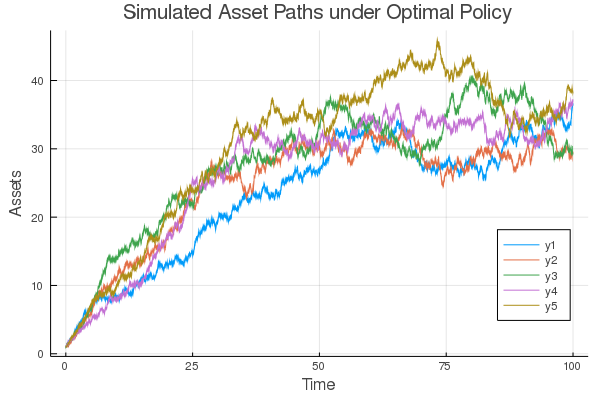

In [393]:
#Simulate Growth Process

using Random, Interpolations

duration=100 #Length of simulation
timestep=0.01 #Step size
nsteps=floor(Int,duration/timestep) #Total number of steps
npaths=5 #How many paths to simulate
initialk=1 #Starting Assets
Random.seed!(100) #Set seed for random number generator
shocks=sqrt(timestep)*sqrt(σ2)*randn(nsteps,npaths) #Discretized and scaled Brownian motion
#Note that, per the fact that increments of Brownian motions have variance proportional
#to time step, scaling must be as square root of time step
simpaths=zeros(nsteps,npaths)
simpaths[1,:]=initialk*ones(1,npaths) #Start all paths at initial k


driftvec=Z*A.^α .+ w .- cons #Optimal drift function at each point of grid 
#drf = interpolate(driftvec,BSpline(Cubic(Interpolations.Line(OnGrid())))) #linear interpolation
#driftfun = scale(drf,A)  #Scale to grid
driftfun=CubicSplineInterpolation(A,driftvec,extrapolation_bc = Line())


for i in 1:npaths
    for t in 2:nsteps
        simpaths[t,i]=simpaths[t-1,i]+driftfun(simpaths[t-1,i])*timestep+sqrt(simpaths[t-1,i])*shocks[t-1,i]
    end
end

tgrid=0:timestep:(duration-timestep) #Time points

plot(tgrid,simpaths,title="Simulated Asset Paths under Optimal Policy",legend=:bottomright)
xlabel!("Time")
ylabel!("Assets")